In [ ]:
!pip install torchinfo -q

In [ ]:
!pip install xlstm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━

In [ ]:
import torch
from torch import nn
from torchinfo import summary

from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

SEQ_LENGTH_XLSTM = 150

In [ ]:
def create_xlstm_model(seq_length, num_blocks, slstm_pos, num_heads=2, conv1d_kernel_size=2, proj_factor=1.1, input_size=1, output_size=1):
    # Define your input size, hidden size, and other relevant parameters
    input_size = input_size  # Number of features in your time series
    embedding_dim = 64  # Dimension of the embeddings, reduced to save memory
    output_size = output_size  # Number of output features (predicting the next value)

    # Define the xLSTM configuration
    cfg = xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(
                conv1d_kernel_size=conv1d_kernel_size, qkv_proj_blocksize=2, num_heads=num_heads  # Reduced parameters to save memory
            )
        ),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(
                backend="cuda",
                num_heads=num_heads,  # Reduced number of heads to save memory
                conv1d_kernel_size=conv1d_kernel_size,  # Reduced kernel size to save memory
                bias_init="powerlaw_blockdependent",
            ),
            feedforward=FeedForwardConfig(proj_factor=proj_factor, act_fn="gelu"),  # Reduced projection factor to save memory
        ),
        context_length=seq_length,
        num_blocks=num_blocks,  # Reduced number of blocks to save memory
        embedding_dim=embedding_dim,
        slstm_at=slstm_pos,
    )

    # Instantiate the xLSTM stack
    xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

    # Add a linear layer to project input data to the required embedding dimension
    input_projection = nn.Linear(input_size, embedding_dim).to("cuda")

    # Add a final linear layer to project the xLSTM output to the desired output size
    output_projection = nn.Linear(embedding_dim, output_size).to("cuda")

    return xlstm_stack, input_projection, output_projection

In [ ]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        architecture = kwargs.get('architecture', 'Unknown Architecture')
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nArchitecture - {architecture} took {elapsed_time:.2f} seconds to train.")
        return result
    return wrapper

In [ ]:
from tqdm import tqdm

@timeit
def train_model(epochs, model, input_projection, output_projection, train_data, optimizer, criterion, architecture=None):

    losses = []

    print(f'Training xLSTM {architecture} for {epochs} epochs...')

    for epoch in range(epochs):
        model.train()

        epoch_loss = 0.0

        progress = tqdm(train_data, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for inputs, targets in progress:
            projected_input_data = input_projection(inputs)
            xlstm_output = model(projected_input_data)
            predictions = output_projection(xlstm_output[:, -1, :])  # Use the last time step's output

            # Ensure the shapes match
            predictions = predictions.squeeze(-1)
            batch_y = targets.squeeze(-1)

            # Compute the loss
            loss = criterion(predictions, batch_y)

            losses.append(loss.cpu().detach().item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping to prevent the exploding gradient problem
            optimizer.step()

            epoch_loss += loss.item()

            progress.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(train_data)
        print(f"Epoch {epoch+1}: Avg Loss = {avg_epoch_loss:.6f}")
        losses.append(avg_epoch_loss)

    return losses

In [ ]:
def train_test_split(dataset, train_percent):
    train_size = int(len(dataset) * train_percent)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    return train, test

In [ ]:
def create_dataset(dataset, seq_len=SEQUENCE_LENGTH):
    dataX, dataY = [], []

    for i in range(len(dataset) - seq_len):
        a = dataset[i:(i + seq_len - 1)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len - 1])

    return torch.Tensor(dataX).to('cuda'), torch.Tensor(dataY).to('cuda')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader(x, y, is_train=True):
    return DataLoader(TensorDataset(x, y), batch_size=BATCH_SIZE, shuffle=True if is_train else False)

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(losses, title=None):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Num. Batch Epochs')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
import numpy as np
import torch

def get_preds(model, input_projection, output_projection, test_data):
    preds = []
    labels = []

    model.eval()

    with torch.no_grad():
        for inputs, label in test_data:
            projected_input_data = input_projection(inputs)
            xlstm_output = model(projected_input_data)
            predictions = output_projection(xlstm_output[:, -1, :])  # Use the last time step's output

            predictions = torch.sigmoid(predictions)

            predictions = predictions.squeeze()
            for pred in predictions:
                preds.append(pred.cpu().item())

            labels.extend(label.cpu().numpy())

    return (np.array(preds) > 0.5).astype(int).reshape(-1, 1), labels

In [ ]:
def plot_original_vs_predicted(original, predicted, scaler, title=None):
    preds_rescaled = scaler.inverse_transform(predicted)
    original_rescaled = scaler.inverse_transform(original.cpu().numpy())

    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.plot(range(len(preds_rescaled)), preds_rescaled, linestyle='--', c='r', label='Predicted')
    plt.plot(range(len(original_rescaled)), original_rescaled, c='b', label='Original')

    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification(y_true, y_pred, title="Confusion Matrix"):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Compute and print metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")


# Dyck Language Generation

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import random

# Data Generator for Dyck Language (Balanced Parentheses)
def generate_dyck(n_samples, max_len=20):
    data = []
    labels = []
    for _ in range(n_samples):
        depth = 0
        s = ''
        while len(s) < max_len:
            if depth == 0:
                s += '('
                depth += 1
            else:
                if random.random() < 0.5:
                    s += '('
                    depth += 1
                else:
                    s += ')'
                    depth -= 1
                    if depth < 0:  # unbalanced
                        break
        s = s[:max_len]
        label = 1 if s.count('(') == s.count(')') and depth == 0 else 0
        s = s.ljust(max_len)
        data.append(s)
        labels.append(label)
    return data, torch.Tensor(labels).to(device)

# Tokenizer and vectorizer
def vectorize_data(sequences, vocab={'(': 0, ')': 1, ' ': 2}):
    vocab_size = len(vocab)
    vec = np.zeros((len(sequences), len(sequences[0]), vocab_size), dtype=np.float32)
    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            vec[i, t, vocab[char]] = 1.0
    return torch.Tensor(vec).to(device)

In [ ]:
max_len = 20
input_dim = 3

    # Create dataset
train_seqs, train_labels = generate_dyck(2000, max_len)
test_seqs, test_labels = generate_dyck(500, max_len)
x_train = vectorize_data(train_seqs)
x_test = vectorize_data(test_seqs)
y_train = torch.Tensor(train_labels)
y_test = torch.Tensor(test_labels)

In [ ]:
train_dataloader = create_dataloader(x_train, y_train)
test_dataloader = create_dataloader(x_test, y_test, is_train=False)

In [ ]:
inp, target = next(iter(train_dataloader))

inp.shape, target.shape, target

(torch.Size([3, 20, 3]),
 torch.Size([3]),
 tensor([0., 0., 0.], device='cuda:0'))

In [ ]:
SEQUENCE_LENGTH=20
BATCH_SIZE=3
INPUT_SIZE=3

## xLSTM Model

In [ ]:
from torch.optim import Adam

num_epochs = 5

xlstm_stack, input_projection, output_projection = create_xlstm_model(SEQUENCE_LENGTH, num_blocks=1, slstm_pos=[0], input_size=3, output_size=1)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entorpy with Logits
optimizer = Adam(list(xlstm_stack.parameters()) + list(input_projection.parameters()) + list(output_projection.parameters()), lr=0.0001)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


In [ ]:
summary(xlstm_stack)

Layer (type:depth-idx)                             Param #
xLSTMBlockStack                                    --
├─ModuleList: 1-1                                  --
│    └─sLSTMBlock: 2-1                             --
│    │    └─LayerNorm: 3-1                         64
│    │    └─sLSTMLayer: 3-2                        16,896
│    │    └─LayerNorm: 3-3                         64
│    │    └─GatedFeedForward: 3-4                  24,576
├─LayerNorm: 1-2                                   64
Total params: 41,664
Trainable params: 41,664
Non-trainable params: 0

In [ ]:
losses = train_model(num_epochs, xlstm_stack, input_projection, output_projection, train_dataloader, optimizer, criterion, architecture='[s]')

Training xLSTM [s] for 5 epochs...


Epoch 1: Avg Loss = 0.339715


Epoch 2: Avg Loss = 0.223148


Epoch 3: Avg Loss = 0.195134


Epoch 4: Avg Loss = 0.166299


Epoch 5: Avg Loss = 0.133072

Architecture - [s] took 31.29 seconds to train.


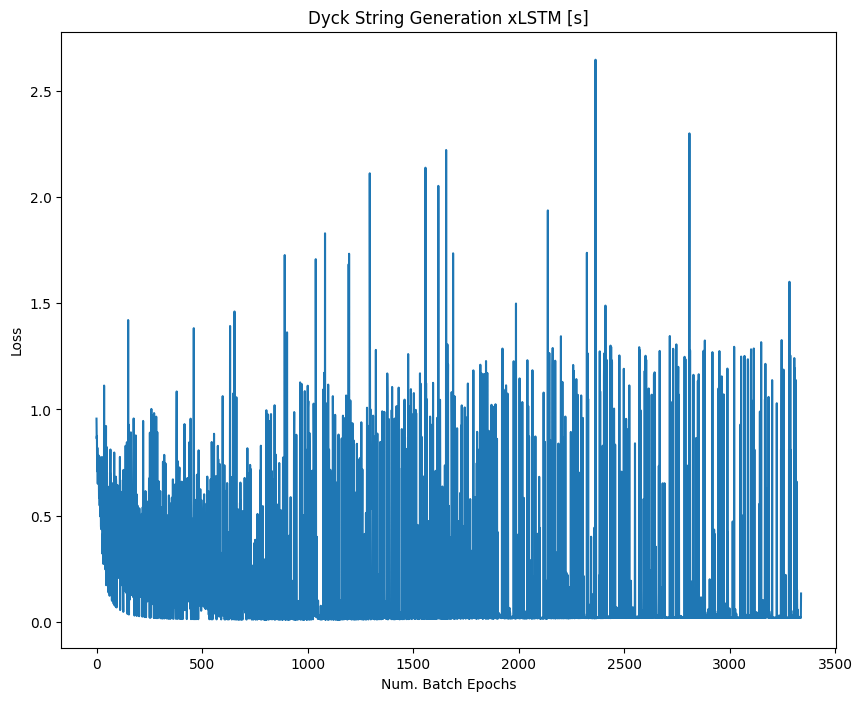

In [ ]:
plot_losses(losses, 'Dyck String Generation xLSTM [s]')

In [ ]:
preds, labels = get_preds(xlstm_stack, input_projection, output_projection, test_dataloader)

In [ ]:
preds = preds.flatten()

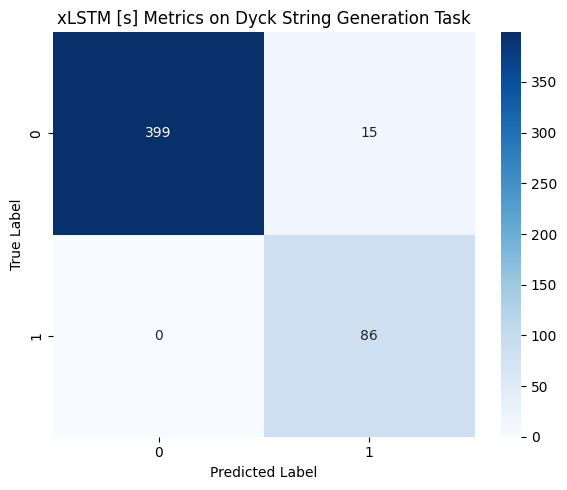

Accuracy:  0.9700
Precision: 0.8515
Recall:    1.0000
F1 Score:  0.9198


In [ ]:
evaluate_classification(y_true=labels, y_pred=preds, title='xLSTM [s] Metrics on Dyck String Generation Task')

## LSTM Model

In [ ]:
import torch
import torch.nn as nn

class DyckLSTMClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=1, dropout=0.1):
        super(DyckLSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, 1)  # binary classification
        # no sigmoid here → use BCEWithLogitsLoss

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_dim)
        final_timestep = lstm_out[:, -1, :]  # take last time step
        logits = self.fc(final_timestep)     # (batch_size, 1)
        return logits

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Instantiate the model
model = DyckLSTMClassifier(input_dim=3, hidden_dim=128).to("cuda")

# Step 2: Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # sigmoid will be applied inside this
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, targets in progress:
            inputs = inputs.to("cuda")
            targets = targets.to("cuda").float()  # BCEWithLogitsLoss needs float

            optimizer.zero_grad()
            logits = model(inputs).squeeze()  # shape: (batch_size,)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}: Avg Loss = {running_loss / len(train_loader):.4f}")

In [ ]:
def get_preds_and_labels(model, test_loader, threshold=0.5):
    preds, labels = [], []
    model.eval()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to("cuda")
            logits = model(inputs).squeeze()
            probs = torch.sigmoid(logits)
            predicted = (probs > threshold).int().cpu().numpy()
            preds.extend(predicted)
            labels.extend(targets.cpu().numpy())

    return np.array(preds), np.array(labels)

In [ ]:
train(model, train_dataloader, criterion, optimizer, epochs=5)

Epoch 1/5: 100%|██████████| 667/667 [00:03<00:00, 209.80it/s, loss=0.0108]


Epoch 1: Avg Loss = 0.4030


Epoch 2/5: 100%|██████████| 667/667 [00:02<00:00, 273.42it/s, loss=0.233]


Epoch 2: Avg Loss = 0.1426


Epoch 3/5: 100%|██████████| 667/667 [00:02<00:00, 272.94it/s, loss=0.00109]


Epoch 3: Avg Loss = 0.0551


Epoch 4/5: 100%|██████████| 667/667 [00:02<00:00, 247.25it/s, loss=0.00396]


Epoch 4: Avg Loss = 0.0233


Epoch 5/5: 100%|██████████| 667/667 [00:02<00:00, 256.12it/s, loss=0.0232]

Epoch 5: Avg Loss = 0.0410


In [ ]:
preds, labels = get_preds_and_labels(model, test_dataloader)

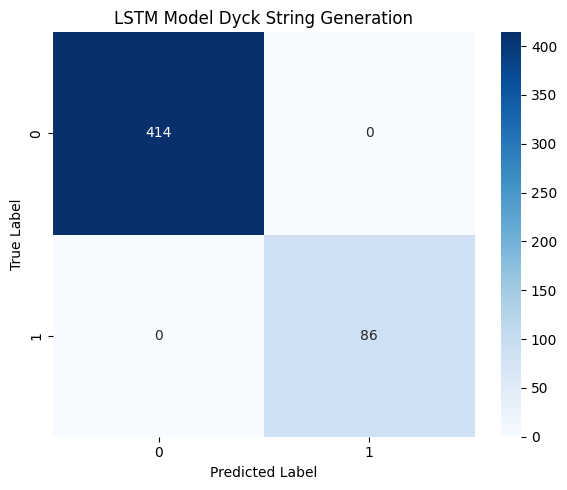

Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


In [ ]:
evaluate_classification(y_true=labels, y_pred=preds, title='LSTM Model Dyck String Generation')

## GRU Model

In [ ]:
import torch
import torch.nn as nn

class DyckGRUClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=1, dropout=0.2):
        super(DyckGRUClassifier, self).__init__()

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)  # Output is a single logit
        self.sigmoid = nn.Sigmoid()        # To turn logit into probability

    def forward(self, x):
        gru_out, _ = self.gru(x)                      # Output: (batch, seq_len, hidden_dim)
        last_hidden = gru_out[:, -1, :]               # Take output from last time step
        logits = self.fc(last_hidden)                 # Output: (batch, 1)
        probs = self.sigmoid(logits)                  # Output: (batch, 1)
        return probs

In [ ]:
# Create the model
gru_model = DyckGRUClassifier().to(device)

# Define loss and optimizer
criterion = nn.BCELoss()                              # Since output is probability (0-1)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

train(gru_model, train_dataloader, criterion, optimizer, epochs=5)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Epoch 1/5: 100%|██████████| 667/667 [00:03<00:00, 197.70it/s, loss=0.0606]


Epoch 1: Avg Loss = 0.3665


Epoch 2/5: 100%|██████████| 667/667 [00:04<00:00, 163.67it/s, loss=0.0647]


Epoch 2: Avg Loss = 0.1402


Epoch 3/5: 100%|██████████| 667/667 [00:02<00:00, 229.68it/s, loss=0.00048]


Epoch 3: Avg Loss = 0.0755


Epoch 4/5: 100%|██████████| 667/667 [00:02<00:00, 239.10it/s, loss=0.0001]


Epoch 4: Avg Loss = 0.0628


Epoch 5/5: 100%|██████████| 667/667 [00:02<00:00, 277.96it/s, loss=0.0007]

Epoch 5: Avg Loss = 0.0324


In [ ]:
preds, labels = get_preds_and_labels(gru_model, test_dataloader)

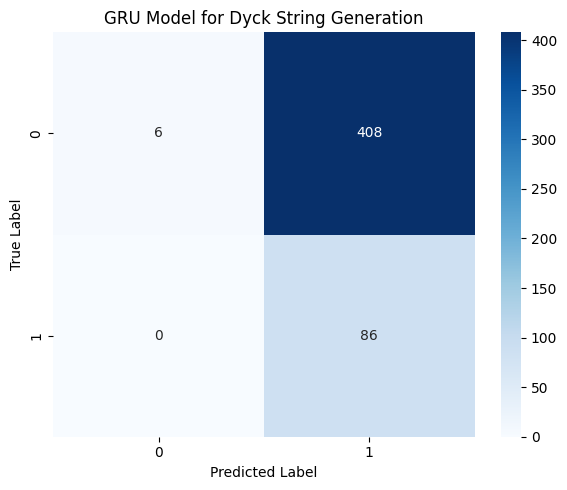

Accuracy:  0.1840
Precision: 0.1741
Recall:    1.0000
F1 Score:  0.2966


In [ ]:
evaluate_classification(y_true=labels, y_pred=preds, title='GRU Model for Dyck String Generation')